Mastering Pairs Trading: A Guide to Algorithmic Strategies in the Stock Market

Aaron De la Rosa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Note: we only want the adjusted close data, ytd
STOCK_A = 'AMD'
STOCK_B = 'TSLA'
raw_data = yf.download(tickers=[STOCK_A, STOCK_B], period='ytd', interval='1d')
raw_data = raw_data.drop(columns=['Close', 'High', 'Low', 'Open', 'Volume'])

# Getting rid of 'TSLA' and 'AMD' as sub-columns under 'Adj Close'... making them separate columns
data = pd.DataFrame()
data[STOCK_A] = raw_data['Adj Close'][STOCK_A]
data[STOCK_B] = raw_data['Adj Close'][STOCK_B]

data

[*********************100%***********************]  2 of 2 completed


,AMD,TSLA
Date,,
2024-01-02,138.580002,248.419998
2024-01-03,135.320007,238.449997
2024-01-04,136.009995,237.929993
2024-01-05,138.580002,237.490005
2024-01-08,146.179993,240.449997
...,...,...
2024-08-30,148.559998,214.110001
2024-09-03,136.940002,210.600006
2024-09-04,140.869995,219.410004


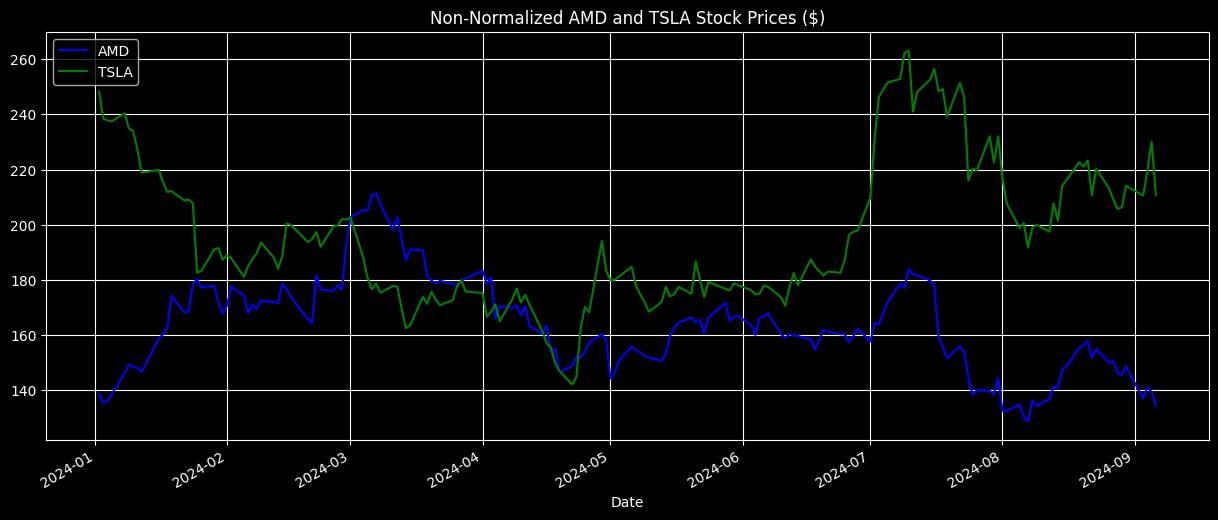

In [5]:
plt.figure(figsize=(15,6))
plt.style.use("dark_background")
axis1 = data[STOCK_A].plot(color='blue', grid=True, label=STOCK_A)
axis2 = data[STOCK_B].plot(color='green', grid=True, label=STOCK_B)
h1, l1 = axis1.get_legend_handles_labels()
h2, l2 = axis2.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.title(label='Non-Normalized AMD and TSLA Stock Prices ($)')
plt.grid(True)
plt.show()

In [6]:
# Normalize the the dataframe using cumulative percentage change
norm_data = pd.DataFrame()

norm_data[STOCK_A] = data[STOCK_A].pct_change().cumsum()
norm_data[STOCK_B] = data[STOCK_B].pct_change().cumsum()

# The first row will contain NaN, since there is no previous row to calculate percent change
norm_data = norm_data.tail(len(data) - 1)

norm_data

,AMD,TSLA
Date,,
2024-01-03,-0.023524,-0.040134
2024-01-04,-0.018425,-0.042314
2024-01-05,0.000470,-0.044164
2024-01-08,0.055312,-0.031700
2024-01-09,0.076382,-0.054532
...,...,...
2024-08-30,0.151401,-0.038085
2024-09-03,0.073183,-0.054479
2024-09-04,0.101882,-0.012646


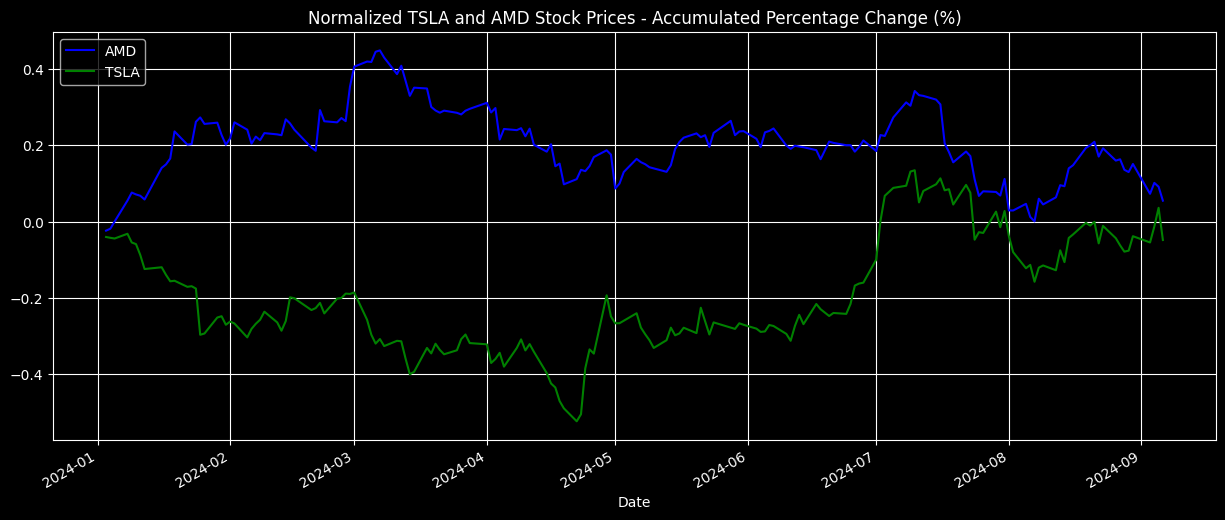

In [8]:
# Replot the data
plt.figure(figsize=(15,6))
axis1 = norm_data[STOCK_A].plot(color='blue', grid=True, label=STOCK_A)
axis2 = norm_data[STOCK_B].plot(color='green', grid=True, label=STOCK_B)
h1, l1 = axis1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.title(label='Normalized TSLA and AMD Stock Prices - Accumulated Percentage Change (%)')
plt.grid(True)
plt.show()

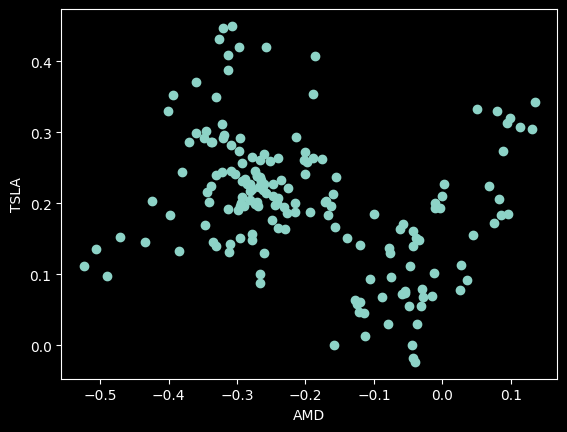

In [9]:
plt.scatter(norm_data[STOCK_B], norm_data[STOCK_A])
plt.xlabel(STOCK_A)
plt.ylabel(STOCK_B)
plt.show()

In [10]:
# Import the statsmodels module with the alias sm
import statsmodels.api as sm

# Now you can use sm to refer to the statsmodels module
X = sm.add_constant(norm_data[STOCK_A])
Y = norm_data[STOCK_B]
model = sm.OLS(Y, X)
model = model.fit()
alpha = model.params[0]
beta = model.params[1]
print(model.params)
print(model.summary())

const   -0.109432
AMD     -0.431918
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   TSLA   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     14.51
Date:                Sun, 08 Sep 2024   Prob (F-statistic):           0.000195
Time:                        17:25:52   Log-Likelihood:                 94.316
No. Observations:                 171   AIC:                            -184.6
Df Residuals:                     169   BIC:                            -178.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

In [11]:
residuals = norm_data[STOCK_B] - (beta * norm_data[STOCK_A]) - alpha
norm_data['Residuals'] = residuals
norm_data

,AMD,TSLA,Residuals
Date,,,
2024-01-03,-0.023524,-0.040134,0.059137
2024-01-04,-0.018425,-0.042314,0.059159
2024-01-05,0.000470,-0.044164,0.065471
2024-01-08,0.055312,-0.031700,0.101622
2024-01-09,0.076382,-0.054532,0.087890
...,...,...,...
2024-08-30,0.151401,-0.038085,0.136739
2024-09-03,0.073183,-0.054479,0.086562
2024-09-04,0.101882,-0.012646,0.140790


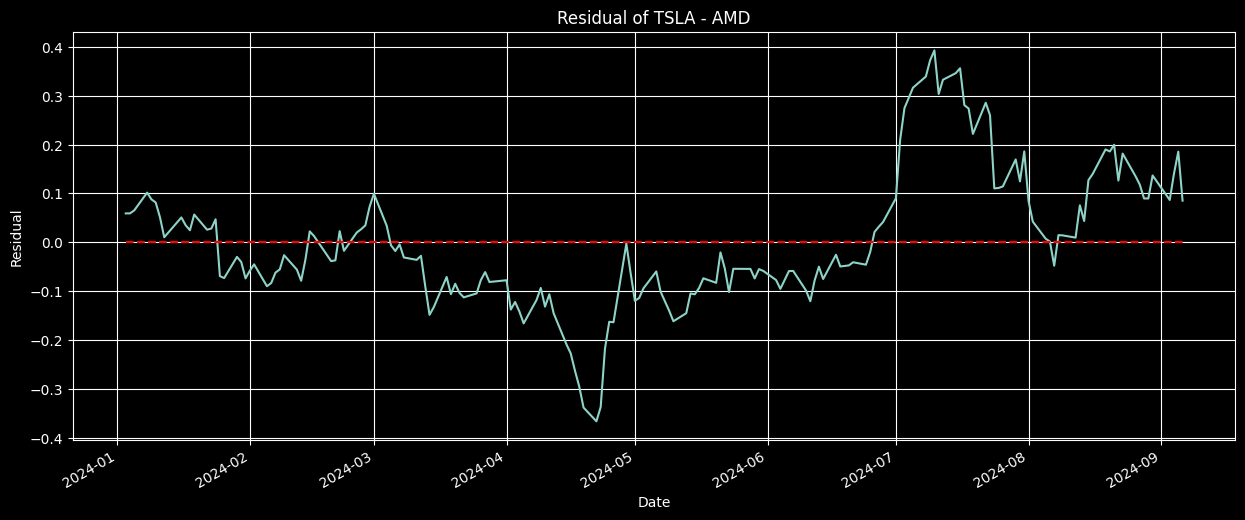

In [12]:
norm_data['Residuals'].plot(figsize=(15,6))
plt.ylabel('Residual')
plt.title('Residual of TSLA - AMD')
# Dashed line showing the mean of the residual
plt.hlines(y=norm_data['Residuals'].mean(), xmin='2024-01-03', xmax='2024-09-06', colors='red', linestyles='dashed')
plt.grid(True)
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(norm_data['Residuals'], maxlag=1)
adf

(-1.9962671536230006,
 0.28821221697695787,
 0,
 170,
 {'1%': -3.469413468959902,
  '5%': -2.8786964197028295,
  '10%': -2.5759166089965397},
 -582.6607422402503)

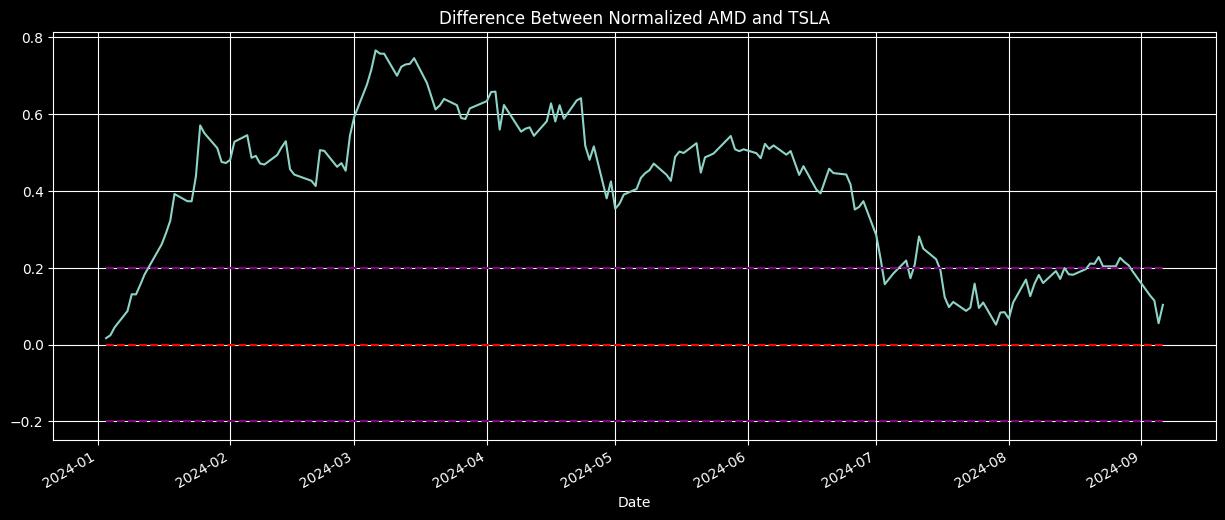

In [14]:
norm_data['Difference'] = norm_data[STOCK_A] - norm_data[STOCK_B]
norm_data['Difference'].plot(figsize=(15,6))
plt.title('Difference Between Normalized AMD and TSLA')
plt.hlines(y=0, xmin='2024-01-03', xmax='2024-09-06', colors='red', linestyles='dashed')
plt.hlines(y=0.2, xmin='2024-01-03', xmax='2024-09-06', colors='purple', linestyles='dashed')
plt.hlines(y=-0.2, xmin='2024-01-03', xmax='2024-09-06', colors='purple', linestyles='dashed')
plt.grid(True)
plt.show()

In [15]:
norm_data.reset_index(inplace=True)
norm_data

,Date,AMD,TSLA,Residuals,Difference
0,2024-01-03,-0.023524,-0.040134,0.059137,0.016609
1,2024-01-04,-0.018425,-0.042314,0.059159,0.023889
2,2024-01-05,0.000470,-0.044164,0.065471,0.044634
3,2024-01-08,0.055312,-0.031700,0.101622,0.087012
4,2024-01-09,0.076382,-0.054532,0.087890,0.130914
...,...,...,...,...,...
166,2024-08-30,0.151401,-0.038085,0.136739,0.189486
167,2024-09-03,0.073183,-0.054479,0.086562,0.127662
168,2024-09-04,0.101882,-0.012646,0.140790,0.114527
169,2024-09-05,0.091730,0.036395,0.185447,0.055336


In [16]:
def print_position(position):
    print('Short Stock: ' + position['short_stock'])
    print('\t' + 'Borrowed & Sold: $' + str(position['short_value_orig']))
    print('\t' + 'Current Buy Price: $' + str(position['short_value_curr']))
    print('Long Stock: ' + position['long_stock'])
    print('\t' + 'Bought: $' + str(position['long_value_orig']))
    print('\t' + 'Current Sell Price: $' + str(position['long_value_curr']))
    print('Total Profit: $' + str(position['total_profit']))
    print('Realized Profit: $' + str(position['realized_profit']))
    print('Total Money Spent: $' + str(position['total_money_spent']))

In [17]:
# Create a new dataframe to store the results of each day in the trading simulation
df_columns = ['Date', 'Buy or Sell', 'Signal', 'Signal Strength', 'Decision', 'Short Stock', 'Borrowed & Sold', 'Current Buy Price', 'Long Stock', 'Bought', 'Current Sell Price', 'Total Profit', 'Realized Profit', 'Total Money Spent']
trading_sim = pd.DataFrame(columns=df_columns)
trading_sim['Date'] = norm_data['Date']

trading_sim

,Date,Buy or Sell,Signal,Signal Strength,Decision,Short Stock,Borrowed & Sold,Current Buy Price,Long Stock,Bought,Current Sell Price,Total Profit,Realized Profit,Total Money Spent
0,2024-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2024-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,2024-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,2024-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,2024-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
position_exists = False
num_inc_days = 0
num_dec_days = 0
num_days_in_close_range = 0

# Assume that on a short position, we have to pay a 5% fee of the stock's price when it is borrowed
position = {
    'short_stock': '',
    'short_value_orig': 0,
    'short_value_curr': 0,
    'long_stock': '',
    'long_value_orig': 0,
    'long_value_curr': 0,
    'total_profit': 0,
    'realized_profit': 0,
    'total_money_spent': 0
}

SIGNAL_THRESHOLD = (5/7) #The minimum requirement for a strong buy/sell signal is 5 days of consecutive movement

# Let us say 7 days is the measure of a 100% strength buy signal
# In other words, if the stock moves in the same direction for a week, we can safely assume we are at a local minimum
ONE_WEEK = 7

for i in range(len(norm_data)):

    if (position_exists):
        # Update the value of stocks - and our total profit - in our position each day
        position['short_value_curr'] = data.iloc[i][position['short_stock']]
        position['long_value_curr'] = data.iloc[i][position['long_stock']]
        short_profit = position['short_value_orig'] - position['short_value_curr']
        long_profit = position['long_value_curr'] - position['long_value_orig']
        position['total_profit'] = short_profit + long_profit + position['realized_profit']

    # Once the end of the trading term is reached, close out whatever position is currently held
    if (position_exists and i == (len(norm_data) - 1)):
            short_profit = position['short_value_orig'] - position['short_value_curr']
            long_profit = position['long_value_curr'] - position['long_value_orig']
            position['realized_profit'] += short_profit + long_profit
            position_exists = False

    # We are in the close-range
    if (abs(norm_data.iloc[i]['Difference']) < 0.2):
        num_days_in_close_range += 1

        # Update 'Buy or Sell' & 'Signal in trading sim
        trading_sim.at[i, 'Buy or Sell'] = 'Sell'
        trading_sim.at[i, 'Signal'] = num_days_in_close_range / ONE_WEEK

        # Strong Sell Signal, Close the Position
        if (position_exists and (num_days_in_close_range / ONE_WEEK) >= SIGNAL_THRESHOLD):
            trading_sim.at[i, 'Signal Strength'] = 'Strong'
            trading_sim.at[i, 'Decision'] = 'Close Position'

            short_profit = position['short_value_orig'] - position['short_value_curr']
            long_profit = position['long_value_curr'] - position['long_value_orig']
            position['realized_profit'] += short_profit + long_profit
            position_exists = False

        # Weak Sell Signal, DO NOT close the position
        elif (position_exists and (num_days_in_close_range / ONE_WEEK) < SIGNAL_THRESHOLD):
            trading_sim.at[i, 'Signal Strength'] = 'Weak'
            trading_sim.at[i, 'Decision'] = 'Maintain Position'

        # We do not currently hold a position, do nothing
        elif (not(position_exists)):
            trading_sim.at[i, 'Decision'] = 'NO POSITION'

    # We are OUTSIDE the close-range
    else:
        num_days_in_close_range = 0

        # Compare today's difference to yesterday, determine direction and change number of inc/dec days
        if (norm_data.iloc[i]['Difference'] > norm_data.iloc[i - 1]['Difference']):
            num_inc_days += 1
            num_dec_days = 0
            trading_sim.at[i, 'Signal'] = num_inc_days / ONE_WEEK

        elif (norm_data.iloc[i]['Difference'] < norm_data.iloc[i - 1]['Difference']):
            num_dec_days += 1
            num_inc_days = 0
            trading_sim.at[i, 'Signal'] = num_dec_days / ONE_WEEK

        # Update 'Buy or Sell' & 'Signal in trading sim
        trading_sim.at[i, 'Buy or Sell'] = 'Buy'

        # We cannot open a new position if we already have a position
        if (position_exists):
            trading_sim.at[i, 'Decision'] = 'ALREADY POSITIONED'

        # We are ABOVE the close-range
        elif (norm_data.iloc[i]['Difference'] > 0.2):

            # Strong buy signal, short A and long B, get their current values, calculate money spent
            if ((num_inc_days/ONE_WEEK) >= SIGNAL_THRESHOLD):
                trading_sim.at[i, 'Signal Strength'] = 'Strong'
                trading_sim.at[i, 'Decision'] = 'Open Position'

                print('STRONG BUY SIGNAL')
                position['short_stock'] = STOCK_A
                position['short_value_orig'] = data.iloc[i][STOCK_A]
                position['short_value_curr'] = data.iloc[i][STOCK_A]
                position['long_stock'] = STOCK_B
                position['long_value_orig'] = data.iloc[i][STOCK_B]
                position['long_value_curr'] = data.iloc[i][STOCK_B]
                position_exists = True
                position['total_money_spent'] = position['long_value_orig'] + (position['short_value_orig'] * 0.05)

            else:
                trading_sim.at[i, 'Signal Strength'] = 'Weak'
                trading_sim.at[i, 'Decision'] = 'No New Position'

        # We are BELOW the close-range
        elif (norm_data.iloc[i]['Difference'] < -0.2):

            # Strong buy signal, short B and long A, get their current values, calculate money spent
            if ((num_dec_days/ONE_WEEK) >= SIGNAL_THRESHOLD):
                trading_sim.at[i, 'Signal Strength'] = 'Strong'
                trading_sim.at[i, 'Decision'] = 'Open Position'

                position['short_stock'] = STOCK_B
                position['short_value_orig'] = data.iloc[i][STOCK_B]
                position['short_value_curr'] = data.iloc[i][STOCK_B]
                position['long_stock'] = STOCK_A
                position['long_value_orig'] = data.iloc[i][STOCK_A]
                position['long_value_curr'] = data.iloc[i][STOCK_A]
                position_exists = True
                position['total_money_spent'] = position['long_value_orig'] + (position['short_value_orig'] * 0.05)
            else:
                trading_sim.at[i, 'Signal Strength'] = 'Weak'
                trading_sim.at[i, 'Decision'] = 'No New Position'

    trading_sim.at[i, 'Short Stock'] = position['short_stock']
    trading_sim.at[i, 'Borrowed & Sold'] = position['short_value_orig']
    trading_sim.at[i, 'Current Buy Price'] = position['short_value_curr']
    trading_sim.at[i, 'Long Stock'] = position['long_stock']
    trading_sim.at[i, 'Bought'] = position['long_value_orig']
    trading_sim.at[i, 'Current Sell Price'] = position['long_value_curr']
    trading_sim.at[i, 'Total Profit'] = position['total_profit']
    trading_sim.at[i, 'Realized Profit'] = position['realized_profit']
    trading_sim.at[i, 'Total Money Spent'] = position['total_money_spent']

STRONG BUY SIGNAL


In [19]:
print_position(position)
print('Profit is ' + str(round(position['total_profit'] / position['total_money_spent'] * 100, 2)) + '% of money spent')

Short Stock: AMD
	Borrowed & Sold: $205.1300048828125
	Current Buy Price: $151.5800018310547
Long Stock: TSLA
	Bought: $180.74000549316406
	Current Sell Price: $239.1999969482422
Total Profit: $112.00999450683594
Realized Profit: $112.00999450683594
Total Money Spent: $190.9965057373047
Profit is 58.65% of money spent
